# ML to find radial velocities using GALAXIA sim withOUT Nearest Neighbors

In [1]:
%matplotlib inline


import matplotlib
import matplotlib.colors as colors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
import sys
import gzip
import matplotlib.gridspec as gridspec
from scipy.stats import norm

matplotlib.rcParams.update({'font.family':'cmr10','font.size': 13})
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['axes.labelsize']=15
plt.rcParams['figure.figsize']=(4,4)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [2]:
data_train = np.load('/tigress/ljchang/DataXGaia/data/galaxia_mock/training_set_500k.npz')
data_val = np.load('/tigress/ljchang/DataXGaia/data/galaxia_mock/validation_set_500k.npz')
data_test = np.load('/tigress/ljchang/DataXGaia/data/galaxia_mock/test_set_500k.npz')
print(data_train.files)
print(data_train['data'].shape)
data_train = data_train['data']
data_val = data_val['data']
data_test = data_test['data']
print(data_train.shape)

['data', 'inds']
(500000, 27)
(500000, 27)


In [3]:
data_cols = ['source_id', 'l', 'b', 'ra', 'dec', 'parallax', 'parallax_error', 
             'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'radial_velocity',
             'photo_g_mean_mag', 'photo_bp_mean_mag', 'photo_rp_mean_mag',
             'x','y','z','vx','vy','vz','r','phi','theta','vr','vphi','vtheta']
#could train on radial_velocity_error

In [4]:
#data = pd.DataFrame(data, columns=data_cols)
#data = data.drop(data[data.parallax < 2].index)

In [5]:
data_train = pd.DataFrame(data_train, columns=data_cols)
data_val = pd.DataFrame(data_val, columns=data_cols)
data_test = pd.DataFrame(data_test, columns=data_cols)

In [6]:
data_train.head()

,source_id,l,b,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,...,z,vx,vy,vz,r,phi,theta,vr,vphi,vtheta
0,1.982681e+18,100.959518,-11.315711,340.952669,46.040300,0.466141,0.024004,-4.809130,0.016194,-3.41899,...,-0.405935,75.965438,217.563643,6.758828,8.659595,166.187223,92.686833,-22.118115,-229.408683,-5.728296
1,4.307716e+18,42.565441,-2.330392,289.370744,7.485264,0.835366,0.049898,0.258942,0.031809,-0.65434,...,-0.033675,-5.753567,220.068300,5.246595,7.164981,173.516221,90.269291,30.542306,-218.011009,-5.390203
2,1.889534e+17,166.725739,0.342907,77.784502,40.176322,3.506600,0.026044,1.908100,0.017570,1.75107,...,0.016707,19.964203,237.381154,10.676289,8.277828,179.546778,89.884363,-18.064278,-237.531647,-10.712769
3,3.343611e+18,195.421753,-4.403162,90.686166,13.413506,2.491830,0.131145,20.358000,0.064988,-10.81480,...,-0.015810,-6.305647,196.029308,28.889011,8.386410,-179.273035,90.108016,3.763531,-196.093532,-28.896158
4,1.744716e+18,60.568085,-24.715437,317.895405,10.623631,1.386750,0.027244,15.680400,0.015235,4.35933,...,-0.286505,-54.022901,213.111588,-5.152046,7.704610,175.750516,92.131101,69.809249,-208.522643,2.557878


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d

In [8]:
#replacing radial velocity column with nonrescaled radial velocity 
#so no inverse_transform needed at the end
#data_train_scaled = data_train_scaled.assign(radial_velocity=data_train['radial_velocity'])
#data_val_scaled = data_val_scaled.assign(radial_velocity=data_val['radial_velocity'])
#data_test_scaled = data_test_scaled.assign(radial_velocity=data_test['radial_velocity'])
l_train = (data_train['l']).values
l_val = (data_val['l']).values

vr_train = (data_train['radial_velocity']).values
vr_val = (data_val['radial_velocity']).values
#print(np.min(vr_real_train))
#print(np.max(vr_real_train))

In [9]:
#Laura's weights 
from scipy.interpolate import interp2d
from tqdm import tqdm
weight_type = "log2d"
lbins2d = np.linspace(0,360,51)
vbins2d = np.linspace(-550,550,51)

lbins2d_centers = (lbins2d[1:]+lbins2d[:-1])/2
vbins2d_centers = (vbins2d[1:]+vbins2d[:-1])/2

counts2d_train = np.histogram2d(l_train,vr_train,bins=[lbins2d,vbins2d])[0]
counts2d_val = np.histogram2d(l_val,vr_val,bins=[lbins2d,vbins2d])[0]

if weight_type == "lin2d":
    invweight_func_train = interp2d(lbins2d_centers,vbins2d_centers,counts2d_train.T)
    invweight_func_val = interp2d(lbins2d_centers,vbins2d_centers,counts2d_val.T)

    invweights2d_train = np.zeros(len(l_train))
    invweights2d_val = np.zeros(len(l_val))

    for i in tqdm(range(len(l_train))):
        invweights2d_train[i] = invweight_func_train(l_train[i],vr_train[i])
    for j in tqdm(range(len(l_val))):
        invweights2d_val[j] = invweight_func_val(l_val[j],vr_val[j])

    weights_train = 1/invweights2d_train

    weights_val = 1/invweights2d_val

    print("Using linear weights in vr and l")

elif weight_type == "log2d":
    invweight_func_train = interp2d(lbins2d_centers,vbins2d_centers,counts2d_train.T)
    invweight_func_val = interp2d(lbins2d_centers,vbins2d_centers,counts2d_val.T)

    invweights2d_train = np.zeros(len(l_train))
    invweights2d_val = np.zeros(len(l_val))

    for i in tqdm(range(len(l_train))):
        invweights2d_train[i] = invweight_func_train(l_train[i],vr_train[i])
    for j in tqdm(range(len(l_val))):
        invweights2d_val[j] = invweight_func_val(l_val[j],vr_val[j])

    weights_train = 1/invweights2d_train
    weights_train = np.log(weights_train)
    weights_train = weights_train - np.min(weights_train) + 1

    weights_val = 1/invweights2d_val
    weights_val = np.log(weights_val)
    weights_val = weights_val - np.min(weights_val) + 1

    print("Using log weights in vr and l")

100%|██████████| 500000/500000 [00:11<00:00, 45030.39it/s]

Using log weights in vr and l


# calculate the training weights
print(np.min(vr_train))
print(np.max(vr_train))
counts_train, bins_train = np.histogram(vr_train,bins=np.linspace(-700,700,51))
#plt.hist(vr_real_train, bins=np.linspace(-10,400,51))
bin_centers_train = (bins_train[1:]+bins_train[:-1])/2
#print(bin_centers_train)
interp_func_train  = interp1d(bin_centers_train,(counts_train).astype('float'))
inv_weights_train = interp_func_train(vr_train)
weights_train = 1/inv_weights_train
#weights_train = np.sqrt(weights_train)
weights_train = np.log(weights_train)
weights_train = weights_train - np.min(weights_train)+1
plt.figure()

plt.hist(weights_train)
print(np.max(weights_train))

# calculate the training weights
counts_val, bins_val = np.histogram(vr_val,bins=np.linspace(-700,700,100))
bin_centers_val = (bins_val[1:]+bins_val[:-1])/2
interp_func_val  = interp1d(bin_centers_val,(counts_val).astype('float'))
inv_weights_val = interp_func_val(vr_val)
weights_val = 1/inv_weights_val
#weights_val = np.sqrt(weights_val)
weights_val = np.log(weights_val)
weights_val = weights_val - np.min(weights_val)+1

print(np.max(weights_val))

In [10]:
data_train['cos(l)'] = data_train['l'].apply(lambda x: np.cos(x))
data_train['sin(l)'] = data_train['l'].apply(lambda x: np.sin(x))
data_train['cos(b)'] = data_train['b'].apply(lambda x: np.cos(x))
data_train['sin(b)'] = data_train['b'].apply(lambda x: np.sin(x))
#data_train['b'] = data_train['b'].apply(lambda x: np.cos(x))
#data_train['pmra'] = data_train['pmra'].apply(lambda x: np.cos(x))
#data_train['pmdec'] = data_train['pmdec'].apply(lambda x: np.cos(x))

data_val['cos(l)'] = data_val['l'].apply(lambda x: np.cos(x))
data_val['sin(l)'] = data_val['l'].apply(lambda x: np.sin(x))
data_val['cos(b)'] = data_val['b'].apply(lambda x: np.cos(x))
data_val['sin(b)'] = data_val['b'].apply(lambda x: np.sin(x))
#data_val['b'] = data_val['b'].apply(lambda x: np.cos(x))
#data_val['pmra'] = data_val['pmra'].apply(lambda x: np.cos(x))
#data_val['pmdec'] = data_val['pmdec'].apply(lambda x: np.cos(x))

data_test['cos(l)'] = data_test['l'].apply(lambda x: np.cos(x))
data_test['sin(l)'] = data_test['l'].apply(lambda x: np.sin(x))
data_test['cos(b)'] = data_test['b'].apply(lambda x: np.cos(x))
data_test['sin(b)'] = data_test['b'].apply(lambda x: np.sin(x))
#data_test['b'] = data_test['b'].apply(lambda x: np.cos(x))
#data_test['pmra'] = data_test['pmra'].apply(lambda x: np.cos(x))
#data_test['pmdec'] = data_test['pmdec'].apply(lambda x: np.cos(x))


In [11]:
data_train.head()

,source_id,l,b,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,...,r,phi,theta,vr,vphi,vtheta,cos(l),sin(l),cos(b),sin(b)
0,1.982681e+18,100.959518,-11.315711,340.952669,46.040300,0.466141,0.024004,-4.809130,0.016194,-3.41899,...,8.659595,166.187223,92.686833,-22.118115,-229.408683,-5.728296,0.909568,0.415556,0.314696,0.949192
1,4.307716e+18,42.565441,-2.330392,289.370744,7.485264,0.835366,0.049898,0.258942,0.031809,-0.65434,...,7.164981,173.516221,90.269291,30.542306,-218.011009,-5.390203,0.153333,-0.988175,-0.688628,-0.725114
2,1.889534e+17,166.725739,0.342907,77.784502,40.176322,3.506600,0.026044,1.908100,0.017570,1.75107,...,8.277828,179.546778,89.884363,-18.064278,-237.531647,-10.712769,-0.975607,-0.219525,0.941781,0.336227
3,3.343611e+18,195.421753,-4.403162,90.686166,13.413506,2.491830,0.131145,20.358000,0.064988,-10.81480,...,8.386410,-179.273035,90.108016,3.763531,-196.093532,-28.896158,0.800296,0.599606,-0.304323,0.952569
4,1.744716e+18,60.568085,-24.715437,317.895405,10.623631,1.386750,0.027244,15.680400,0.015235,4.35933,...,7.704610,175.750516,92.131101,69.809249,-208.522643,2.557878,-0.638827,-0.769351,0.914185,0.405298


In [12]:
data_cols = ['source_id', 'l', 'b', 'ra', 'dec', 'parallax', 'parallax_error', 
             'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'radial_velocity',
             'photo_g_mean_mag', 'photo_bp_mean_mag', 'photo_rp_mean_mag',
             'x','y','z','vx','vy','vz','r','phi','theta','vr','vphi','vtheta','cos(l)','sin(l)','cos(b)','sin(b)']

In [13]:
SS = StandardScaler()
mu = np.mean((data_train['radial_velocity']).values)
stddev = np.std((data_train['radial_velocity']).values)
data_train_scaled = SS.fit_transform(data_train)
data_val_scaled = SS.transform(data_val)
data_test_scaled = SS.transform(data_test)

In [14]:
data_train_scaled = pd.DataFrame(data_train_scaled, columns=data_cols)
data_val_scaled = pd.DataFrame(data_val_scaled, columns=data_cols)
data_test_scaled = pd.DataFrame(data_test_scaled, columns=data_cols)

In [15]:
use_cols = ['l', 'b','parallax','pmra','pmdec','x','y','z','cos(l)','sin(b)']
# Make the design matrix
X_train = data_train_scaled[use_cols].values
y_train = (data_train_scaled['radial_velocity']).values

X_val = data_val_scaled[use_cols].values
y_val = (data_val_scaled['radial_velocity']).values

X_test = data_test_scaled[use_cols].values
y_test = (data_test_scaled['radial_velocity']).values

In [16]:
print(len(use_cols))

10


In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

Using TensorFlow backend.


In [18]:
from keras import backend as K
from keras import callbacks as callbacks
global index 
import tensorflow as tf

In [19]:
def LikelihoodLossFunction(y_true, y_pred):
    # shape of y_pred should be (nsamples, 2)
    # the first column should be the mean of the prediction
    # the second column is the confidence (number of standard deviations)
#     print y_true.shape
#     print y_pred.shape
    SIGMA = K.abs(y_pred[:, 1]) + 1e-6

    LOC = y_pred[:, 0]
    
    X = y_true[:, 0]
    weights = y_true[:,1]
    ARG = K.abs(X - LOC) / (2 * K.abs(SIGMA))
    PREFACT = K.log(K.pow(2 * np.pi * K.square(SIGMA), -0.5))
    return K.mean((ARG - PREFACT) * weights)


In [20]:
def ConstantLikelihoodLossFunction(y_true, y_pred):
    # shape of y_pred should be (nsamples, 2)
    # the first column should be the mean of the prediction
    # the second column is the confidence (number of standard deviations)
#     print y_pred.shape
    LOC = y_pred[:,0]
    X = y_true[:, 0]
    weights = y_true[:,1]
    ARG = K.square(X - LOC) / (2.0)
    PREFACT = K.log(K.pow(2 * np.pi, -0.5))
    return K.mean((ARG - PREFACT) * weights)

# Two network technique to calculate the error

In [21]:
from sklearn.neighbors import NearestNeighbors
from keras.utils import Sequence
from keras.layers import Input, Dense, Lambda, Concatenate, Dropout, Activation, Add
from keras.models import Model
from keras.utils import plot_model
from IPython.display import clear_output
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

10.424070811636627


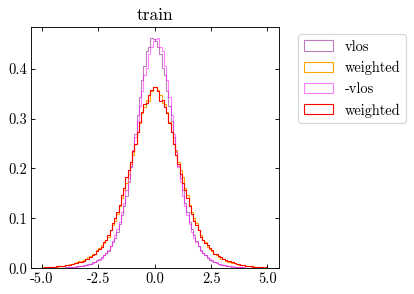

In [22]:
y_low = -5
y_high = 5
bin_num = 100
plt.hist((data_train_scaled['radial_velocity']).values, bins=bin_num, range=(y_low,y_high), histtype='step', edgecolor = 'purple', color= 'skyblue', label = 'vlos', alpha=0.5, density = True)
plt.hist((data_train_scaled['radial_velocity']).values, weights = weights_train, bins=bin_num, range=(y_low,y_high), histtype='step', color= 'orange', label = 'weighted', density = True)
plt.hist(-(data_train_scaled['radial_velocity']).values, bins=bin_num, range=(y_low,y_high), histtype='step', edgecolor = 'magenta', color= 'pink',  label = '-vlos', alpha = 0.5, density = True)
plt.hist(-(data_train_scaled['radial_velocity']).values, weights = weights_train, bins=bin_num, range=(y_low,y_high), histtype='step', color= 'red', label = 'weighted', density = True)
#plt.hist(y[:,0], bins=bin_num, range=(y_low,y_high), histtype='step', color= 'blue',  label = 'unweighted after loader', density = True)
#plt.hist(y[:,0], bins=bin_num, weights = y[:,1], range=(y_low,y_high), histtype='step', color= 'red', label = 'weighed after loader', density = True)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('train')
print(np.max(weights_train))

In [23]:
print(np.shape(y_train))
print(np.shape(weights_train))
print(np.shape(np.vstack([y_train, weights_train]).T))

(500000,)
(500000,)
(500000, 2)


In [24]:
y_train = np.vstack([y_train, weights_train]).T
y_val = np.vstack([y_val, weights_val]).T

In [25]:
# del(inputs, MeanEst, MeanModel, ConfEst, ConfModel)
inputs = Input(shape=(len(use_cols),))
nlayers = 30
MeanEst = (Dense(nlayers, activation='tanh'))(inputs)
MeanEst = (Dropout(0.1))(MeanEst)
MeanEst = (Dense(nlayers, activation='tanh'))(MeanEst)
MeanEst = (Dropout(0.1))(MeanEst)
MeanEst = (Dense(nlayers, activation='tanh'))(MeanEst)
MeanEst = (Dropout(0.1))(MeanEst)
MeanEst = (Dense(nlayers, activation='tanh'))(MeanEst)
MeanEst = (Dropout(0.1))(MeanEst)
MeanEst = (Dense(1, activation='linear'))(MeanEst)
MeanModel = Model(inputs=[inputs], outputs=MeanEst)

ConfEst= (Dense(nlayers, activation='tanh'))(inputs)
ConfEst = (Dropout(0.1))(ConfEst)
ConfEst= (Dense(nlayers, activation='tanh'))(ConfEst)
ConfEst = (Dropout(0.1))(ConfEst)
ConfEst= (Dense(nlayers, activation='tanh'))(ConfEst)
ConfEst = (Dropout(0.1))(ConfEst)
ConfEst= (Dense(nlayers, activation='tanh'))(ConfEst)
ConfEst = (Dropout(0.1))(ConfEst)
ConfEst= (Dense(1, activation='relu'))(ConfEst)
ConfModel = Model(inputs=[inputs], outputs=ConfEst)
#how can this give me a confidence output? the only thing that appears to define a confidence is the relu
#on the last layer...think about this.
#CombinedSub = Concatenate(axis=-1)([MeanEst, ConfEst])
CombinedSub = Concatenate(axis=-1)([MeanModel(inputs), ConfModel(inputs)])

CombinedModel = Model(inputs=[inputs], outputs=CombinedSub)

In [26]:
#CombinedModel.save_weights('modelsIterate/TrainingBoth_0000.hdf5')

In [27]:
CombinedModel.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            3151        input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            3151        input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2)            0           model_1[1][0]                    
                                                                 model_2[1][0]              

In [28]:
import os
num_samp = '500k'
act_func = 'tanh'
neurons = 'D30'
dropout = 'p1dropout'
input_vars = 'lbpppxyzsinbcosl'
lweights = 'log2dweights'
spec = 'CORRECT'
folder_name = 'G_train_2it_'+num_samp+'_'+act_func+'_'+neurons+'_'+dropout+'_'+input_vars+'_'+lweights+'_'+spec
filename = 'plots_test_2it_'+num_samp+'_'+act_func+'_'+neurons+'_'+dropout+'_'+input_vars+'_'+lweights+'_'+spec
print(folder_name)
if not os.path.exists('/tigress/dropulic/'+folder_name):
    os.makedirs(folder_name)
    os.makedirs(folder_name+'/models_GALAXIA_nonn')
    os.makedirs(folder_name+'/logs')
if (os.path.exists('/tigress/dropulic/'+folder_name) and not os.path.exists('/tigress/dropulic/'+folder_name+'/models_GALAXIA_nonn')):
    os.makedirs(folder_name+'/models_GALAXIA_nonn')
    os.makedirs(folder_name+'/logs')

G_train_2it_500k_tanh_D30_p1dropout_lbpppxyzsinbcosl_log2dweights_CORRECT


folder_name = 'G_train_2it_500k_tanh_D30_p1dropout_lbpppxyzsinbcosl_log2dweights'
filename = 'plots_test_2it_500k_tanh_D30_p1dropout_lbpppxyzsinbcosl_log2dweights'

## First training iteration

In [29]:
CheckPoint = ModelCheckpoint(folder_name+'/models_GALAXIA_nonn/TrainingMean_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES = EarlyStopping(patience=40, verbose=True, restore_best_weights=True)
RLR = ReduceLROnPlateau(patience=10, min_lr=1e-5, verbose=True)
CSV_logger = CSVLogger(filename=folder_name+'/logs/training_mean.log', separator=',', append=False)

mycallbacks = [CheckPoint, ES, RLR, CSV_logger]
#mycallbacks = [ES, RLR]

In [30]:
ConfModel.trainable = False
MeanModel.trainable = True
CombinedModel.compile(loss=ConstantLikelihoodLossFunction,
                      optimizer='adam'
                     )
history = CombinedModel.fit(X_train,y_train,
                  validation_data=(X_val, y_val),
                  epochs=1000,
                  batch_size=10000,
                  callbacks = mycallbacks
                 )

Train on 500000 samples, validate on 500000 samples
Epoch 1/1000
500000/500000 [==============================] - 3s 6us/step - loss: 3.4020 - val_loss: 3.2716
Epoch 2/1000
500000/500000 [==============================] - 3s 5us/step - loss: 3.2887 - val_loss: 3.1850
Epoch 3/1000
500000/500000 [==============================] - 3s 5us/step - loss: 3.2359 - val_loss: 3.1489
Epoch 4/1000
500000/500000 [==============================] - 3s 5us/step - loss: 3.2104 - val_loss: 3.1348
Epoch 5/1000
500000/500000 [==============================] - 3s 5us/step - loss: 3.1989 - val_loss: 3.1261
Epoch 6/1000
500000/500000 [==============================] - 3s 5us/step - loss: 3.1844 - val_loss: 3.1196
Epoch 7/1000
500000/500000 [==============================] - 3s 5us/step - loss: 3.1770 - val_loss: 3.1100
Epoch 8/1000
500000/500000 [==============================] - 3s 5us/step - loss: 3.1653 - val_loss: 3.1015
Epoch 9/1000
500000/500000 [==============================] - 3s 5us/step - loss: 3.

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substitutin

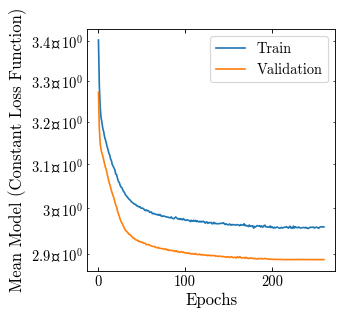

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Mean Model (Constant Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

In [32]:
CheckPoint2 = ModelCheckpoint(folder_name+'/models_GALAXIA_nonn/TrainingErrorBars_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES2 = EarlyStopping(patience=40, verbose=True, restore_best_weights=True)
RLR2 = ReduceLROnPlateau(patience=10, min_lr=1e-5)
CSV_logger2 = CSVLogger(filename=folder_name+'/logs/training_errorbars.log', separator=',', append=False)

mycallbacks2 = [CheckPoint2, ES2, RLR2, CSV_logger2]
#mycallbacks2 = [ES2, RLR2]

In [33]:
ConfModel.trainable = True
MeanModel.trainable = False
CombinedModel.compile(loss=LikelihoodLossFunction,
                      optimizer='adam'
                     )

history = CombinedModel.fit(X_train,y_train,
                  validation_data=(X_val, y_val),
                  epochs=1000,
                  batch_size=10000,
                  callbacks = mycallbacks2
                 )

Train on 500000 samples, validate on 500000 samples
Epoch 1/1000
500000/500000 [==============================] - 3s 6us/step - loss: 334121.6387 - val_loss: 269124.4378
Epoch 2/1000
500000/500000 [==============================] - 3s 5us/step - loss: 197182.6858 - val_loss: 111325.6222
Epoch 3/1000
500000/500000 [==============================] - 3s 5us/step - loss: 62892.9648 - val_loss: 9971.5107
Epoch 4/1000
500000/500000 [==============================] - 3s 5us/step - loss: 14358.2333 - val_loss: 3514.5715
Epoch 5/1000
500000/500000 [==============================] - 3s 5us/step - loss: 12632.2517 - val_loss: 3114.0214
Epoch 6/1000
500000/500000 [==============================] - 3s 5us/step - loss: 10691.4087 - val_loss: 2058.0081
Epoch 7/1000
500000/500000 [==============================] - 3s 5us/step - loss: 7299.1121 - val_loss: 382.5748
Epoch 8/1000
500000/500000 [==============================] - 3s 5us/step - loss: 9287.6220 - val_loss: 2443.1310
Epoch 9/1000
500000/50000

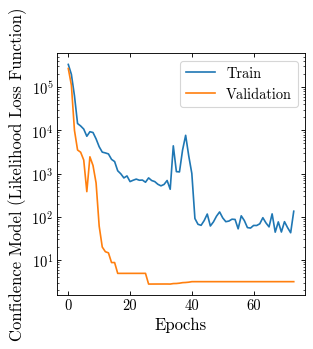

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Confidence Model (Likelihood Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

## Second Training Iteration

In [35]:
CheckPoint4 = ModelCheckpoint(folder_name+'/models_GALAXIA_nonn/TrainingMean2_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES4 = EarlyStopping(patience=40, verbose=True, restore_best_weights=True)
RLR4 = ReduceLROnPlateau(patience=10, min_lr=1e-5, verbose=True)
CSV_logger4 = CSVLogger(filename=folder_name+'/logs/training_mean2.log', separator=',', append=False)

mycallbacks4 = [CheckPoint4, ES4, RLR4, CSV_logger4]
#mycallbacks4 = [ES4, RLR4]

In [36]:
ConfModel.trainable = False
MeanModel.trainable = True
CombinedModel.compile(loss=ConstantLikelihoodLossFunction,
                      optimizer='adam'
                     )
history = CombinedModel.fit(X_train,y_train,
                  validation_data=(X_val, y_val),
                  epochs=1000,
                  batch_size=10000,
                  callbacks = mycallbacks4
                 )

Train on 500000 samples, validate on 500000 samples
Epoch 1/1000
500000/500000 [==============================] - 3s 6us/step - loss: 2.9578 - val_loss: 2.8881
Epoch 2/1000
500000/500000 [==============================] - 3s 6us/step - loss: 2.9571 - val_loss: 2.8890
Epoch 3/1000
500000/500000 [==============================] - 3s 5us/step - loss: 2.9578 - val_loss: 2.8880
Epoch 4/1000
500000/500000 [==============================] - 3s 5us/step - loss: 2.9567 - val_loss: 2.8877
Epoch 5/1000
500000/500000 [==============================] - 3s 5us/step - loss: 2.9574 - val_loss: 2.8879
Epoch 6/1000
500000/500000 [==============================] - 3s 5us/step - loss: 2.9573 - val_loss: 2.8876
Epoch 7/1000
500000/500000 [==============================] - 3s 5us/step - loss: 2.9584 - val_loss: 2.8885
Epoch 8/1000
500000/500000 [==============================] - 3s 5us/step - loss: 2.9570 - val_loss: 2.8876
Epoch 9/1000
500000/500000 [==============================] - 3s 5us/step - loss: 2.

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substitutin

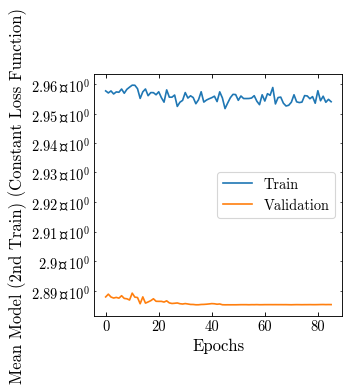

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Mean Model (2nd Train) (Constant Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

In [38]:
CheckPoint5 = ModelCheckpoint(folder_name+'/models_GALAXIA_nonn/TrainingErrorBars2_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES5 = EarlyStopping(patience=40, verbose=True, restore_best_weights=True)
RLR5 = ReduceLROnPlateau(patience=10, min_lr=1e-5)
CSV_logger5 = CSVLogger(filename=folder_name+'/logs/training_errorbars2.log', separator=',', append=False)

mycallbacks5 = [CheckPoint5, ES5, RLR5, CSV_logger5]
#mycallbacks5 = [ES5, RLR5]

In [39]:
ConfModel.trainable = True
MeanModel.trainable = False
CombinedModel.compile(loss=LikelihoodLossFunction,
                      optimizer='adam'
                     )

history = CombinedModel.fit(X_train,y_train,
                  validation_data=(X_val, y_val),
                  epochs=1000,
                  batch_size=10000,
                  callbacks = mycallbacks5
                 )

Train on 500000 samples, validate on 500000 samples
Epoch 1/1000
500000/500000 [==============================] - 3s 7us/step - loss: 135.2303 - val_loss: 2.9013
Epoch 2/1000
500000/500000 [==============================] - 3s 6us/step - loss: 118.1896 - val_loss: 2.8850
Epoch 3/1000
500000/500000 [==============================] - 3s 6us/step - loss: 85.7516 - val_loss: 2.8615
Epoch 4/1000
500000/500000 [==============================] - 3s 6us/step - loss: 59.0786 - val_loss: 2.8682
Epoch 5/1000
500000/500000 [==============================] - 3s 6us/step - loss: 108.4411 - val_loss: 2.8224
Epoch 6/1000
500000/500000 [==============================] - 3s 6us/step - loss: 369.5019 - val_loss: 2.8112
Epoch 7/1000
500000/500000 [==============================] - 3s 6us/step - loss: 1749.5758 - val_loss: 2.8653
Epoch 8/1000
500000/500000 [==============================] - 3s 6us/step - loss: 24.4786 - val_loss: 2.9013
Epoch 9/1000
500000/500000 [==============================] - 3s 6us/s

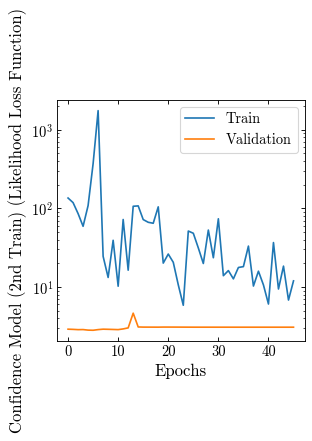

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Confidence Model (2nd Train) (Likelihood Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

## Third Training Iteration

In [ ]:
CheckPoint6 = ModelCheckpoint(folder_name+'/models_GALAXIA_nonn/TrainingMean3_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES4 = EarlyStopping(patience=40, verbose=True, restore_best_weights=True)
RLR4 = ReduceLROnPlateau(patience=10, min_lr=1e-5, verbose=True)
CSV_logger6 = CSVLogger(filename=folder_name+'/logs/training_mean3.log', separator=',', append=False)

mycallbacks6 = [CheckPoint6, ES4, RLR4, CSV_logger6]
#mycallbacks4 = [ES4, RLR4]

In [ ]:
ConfModel.trainable = False
MeanModel.trainable = True
CombinedModel.compile(loss=ConstantLikelihoodLossFunction,
                      optimizer='adam'
                     )
history = CombinedModel.fit(X_train,y_train,
                  validation_data=(X_val, y_val),
                  epochs=1000,
                  batch_size=10000,
                  callbacks = mycallbacks6
                 )

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Mean Model (3rd Train) (Constant Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
CheckPoint7 = ModelCheckpoint(folder_name+'/models_GALAXIA_nonn/TrainingErrorBars3_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES5 = EarlyStopping(patience=40, verbose=True, restore_best_weights=True)
RLR5 = ReduceLROnPlateau(patience=10, min_lr=1e-5)
CSV_logger7 = CSVLogger(filename=folder_name+'/logs/training_errorbars3.log', separator=',', append=False)

mycallbacks7 = [CheckPoint7, ES5, RLR5, CSV_logger7]
#mycallbacks5 = [ES5, RLR5]

In [ ]:
ConfModel.trainable = True
MeanModel.trainable = False
CombinedModel.compile(loss=LikelihoodLossFunction,
                      optimizer='adam'
                     )

history = CombinedModel.fit(X_train,y_train,
                  validation_data=(X_val, y_val),
                  epochs=1000,
                  batch_size=10000,
                  callbacks = mycallbacks7,
                 )

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Confidence Model (3rd Train) (Likelihood Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

## Train Both

In [41]:
CheckPoint3 = ModelCheckpoint(folder_name+'/models_GALAXIA_nonn/TrainingBoth_{epoch:04d}.hdf5',
                             verbose=0,
                             save_best_only=False
                            )
ES3 = EarlyStopping(patience=40, verbose=True, restore_best_weights=True)
RLR3 = ReduceLROnPlateau(patience=10, min_lr=1e-5)
CSV_logger3 = CSVLogger(filename=folder_name+'/logs/training_both.log', separator=',', append=False)

mycallbacks3 = [CheckPoint3, ES3, RLR3, CSV_logger3]
#mycallbacks3 = [ES3, RLR3]

In [42]:
ConfModel.trainable = True
MeanModel.trainable = True
CombinedModel.compile(loss=LikelihoodLossFunction,
                      optimizer='adam'
                     )

history = CombinedModel.fit(X_train,y_train,
                  validation_data=(X_val, y_val),
                  epochs=1000,
                  batch_size=10000,
                  callbacks = mycallbacks3
                 )

Train on 500000 samples, validate on 500000 samples
Epoch 1/1000
500000/500000 [==============================] - 4s 8us/step - loss: 246.0505 - val_loss: 2.5290
Epoch 2/1000
500000/500000 [==============================] - 3s 7us/step - loss: 120.0761 - val_loss: 2.6741
Epoch 3/1000
500000/500000 [==============================] - 4s 8us/step - loss: 30.5182 - val_loss: 2.6975
Epoch 4/1000
500000/500000 [==============================] - 4s 7us/step - loss: 42.5095 - val_loss: 2.6816
Epoch 5/1000
500000/500000 [==============================] - 3s 7us/step - loss: 124.2468 - val_loss: 2.7411
Epoch 6/1000
500000/500000 [==============================] - 3s 7us/step - loss: 113.0739 - val_loss: 2.8872
Epoch 7/1000
500000/500000 [==============================] - 3s 7us/step - loss: 193.5064 - val_loss: 3.0231
Epoch 8/1000
500000/500000 [==============================] - 3s 7us/step - loss: 25.6550 - val_loss: 3.0466
Epoch 9/1000
500000/500000 [==============================] - 3s 7us/st

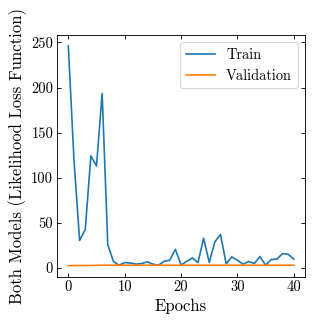

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Both Models (Likelihood Loss Function)')
plt.legend(['Train', 'Validation'])
plt.savefig('Loss_Plot_Iterate.png')
plt.show()

In [44]:
CombinedModel.save_weights(folder_name+"/models_GALAXIA_nonn/ModelWeights.h5")

In [ ]:
 def plot_validation(i,type1):   
    y_low = -700
    y_high = 700
    plt.figure(figsize=(12, 12))
    gs0 = gridspec.GridSpec(3, 3, hspace=0.3, wspace=0.3)

    from matplotlib.colors import LogNorm
    plt.subplot(gs0[3])
    plt.hist2d( test_preds[:,1],test_preds[:,0], bins=40,norm = LogNorm())
    clb1 = plt.colorbar()
    clb1.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel('$\sigma$',labelpad=-10)

    plt.subplot(gs0[4])
    sc = plt.scatter(y_val[:,0], test_preds[:,0], c =test_preds[:,1], label = 'data',marker = '.',cmap=plt.cm.YlOrRd)
    x1 = np.linspace(y_low,y_high,1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.xlim([y_low, y_high])
    plt.ylim([y_low,y_high])
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel(r'$v_{\rm{los}}^{\rm{meas}}$')
    clb2 = plt.colorbar(sc)
    clb2.set_label('$\sigma$', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.clim(0,750)

    plt.subplot(gs0[2])
    hb = plt.hexbin(y_val[:,0], test_preds[:,0],gridsize=80, norm = LogNorm())
    x1 = np.linspace(np.min(y_val[:,0]),np.max(y_val[:,0]),1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel(r'$v_{\rm{los}}^{\rm{meas}}$')
    clb3 = plt.colorbar(hb)
    clb3.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)


    plt.subplot(gs0[5])
    sc = plt.scatter(y_val[:,0], test_preds[:,0], c =test_preds[:,1], label = 'data',marker = '.',cmap=plt.cm.YlOrRd)
    x1 = np.linspace(y_low,y_high,1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.xlim([y_low, y_high])
    plt.ylim([y_low,y_high])
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel(r'$v_{\rm{los}}^{\rm{meas}}$')
    clb4 = plt.colorbar(sc)
    clb4.set_label('$\sigma$\n(saturated)', labelpad=-25, y=1.15, rotation=0,fontsize=10)
    plt.clim(0,200)

    plt.subplot(gs0[6])
    plt.hist2d(X_val[:,2], test_preds[:,1], bins=40, norm = LogNorm())
    clb5 = plt.colorbar()
    clb5.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.xlabel('Distance',fontsize = 12)
    plt.ylabel('$\sigma$',labelpad=-5)

    plt.subplot(gs0[1])
    plotrange = np.linspace(-5,5,1000)
    diff_hist = np.divide(np.subtract(test_preds[:,0],y_val[:,0]),test_preds[:,1])
    mean_diffs, mean_stds = np.mean(diff_hist), np.std(diff_hist)
    plt.hist(diff_hist,bins=20, range=(-5,5), histtype='step',color = 'lightseagreen',linewidth = 1.5, density = True)
    plt.plot(plotrange, norm.pdf(plotrange, mean_diffs, mean_stds),color = 'darkorange', linestyle = '--', linewidth = 2.5,label = 'normal fit')
    plt.yscale('log')
    plt.legend(loc = "upper right",prop={'size': 8})
    plt.xlabel(r'$(v_{\rm{los}}^{\rm{pred}} - v_{\rm{los}}^{\rm{meas}})/\sigma$',labelpad=-5)
    
    plt.subplot(gs0[7])
    diff_hist_err = np.subtract(test_preds[:,0],y_val[:,0])
    plt.hist2d(test_preds[:,1],diff_hist_err, bins=40,norm = LogNorm())
    clb6 = plt.colorbar()
    clb6.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.plot(x1,y1,'k--')
    plt.ylabel(r'$(v_{\rm{los}}^{\rm{pred}} - v_{\rm{los}}^{\rm{meas}})$',labelpad=-5)
    plt.xlabel('$\sigma$',labelpad=-5)

    plt.subplot(gs0[0])
    plt.hist(y_val[:,0], bins=25, range=(y_low,y_high), histtype='step', edgecolor = 'skyblue', color= 'skyblue', fill = True, label = 'val' )
    plt.hist(test_preds[:,0], bins=25, range=(y_low,y_high), histtype='step',color = 'blue', label = 'predicted')
    plt.xlabel(r'$v_{\rm{los}}$', labelpad =-2)
    plt.title('Validation set, Train '+type1+', Epoch '+str(i)+', 20 bins',fontsize=14)
    plt.yscale('log')
    plt.legend(loc = "upper right",prop={'size': 10})
    
    plt.savefig('plots'+type1+'/'+'train'+type1+'_'+str(i)+'.png')
    clb1.remove()
    clb2.remove()
    clb3.remove()
    clb4.remove()
    clb5.remove()
    clb6.remove()

#### Plotting First Training

In [ ]:
traininmean = [file for file in os.listdir('models/')
               if file.startswith('TrainingMean_')]
traininmean = sorted(traininmean)[1::10]

In [ ]:
%%capture
for i, mfile in enumerate(traininmean):
    CombinedModel.load_weights('models/' + mfile)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i*10,'Mean1');

In [ ]:
traininerror = [file for file in os.listdir('models/')
               if file.startswith('TrainingErrorBars_')]
traininerror = sorted(traininerror)[0::20]

In [ ]:
%%capture
for i_err, mfile_err in enumerate(traininerror):
    CombinedModel.load_weights('models/' + mfile_err)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i_err*20,'Error1');

#### Plotting Second Training

In [ ]:
traininmean2 = [file for file in os.listdir('models/')
               if file.startswith('TrainingMean2')]
traininmean2 = sorted(traininmean2)[0::10]

In [ ]:
%%capture
for i, mfile in enumerate(traininmean2):
    CombinedModel.load_weights('models/' + mfile)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i*10,'Mean2');

In [ ]:
traininerror2 = [file for file in os.listdir('models/')
               if file.startswith('TrainingErrorBars2')]
traininerror2 = sorted(traininerror2)[0::20]

In [ ]:
%%capture
for i_err, mfile_err in enumerate(traininerror2):
    CombinedModel.load_weights('models/' + mfile_err)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i_err*20,'Error2');

#### Plotting Third Training

In [ ]:
traininmean3 = [file for file in os.listdir('models/')
               if file.startswith('TrainingMean3')]
traininmean3 = sorted(traininmean3)[0::10]

In [ ]:
%%capture
for i, mfile in enumerate(traininmean3):
    CombinedModel.load_weights('models/' + mfile)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i*10,'Mean3');

In [ ]:
traininerror3 = [file for file in os.listdir('models/')
               if file.startswith('TrainingErrorBars3')]
traininerror3 = sorted(traininerror3)[0::20]

In [ ]:
%%capture
for i_err, mfile_err in enumerate(traininerror3):
    CombinedModel.load_weights('models/' + mfile_err)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i_err*20,'Error3');

#### Plot results of training both

In [ ]:
traininboth = [file for file in os.listdir('models/')
               if file.startswith('TrainingBoth')]
traininboth = sorted(traininboth)[1::10]


In [ ]:
%%capture
for i_both, mfile_both in enumerate(traininboth):
    CombinedModel.load_weights('models/' + mfile_both)
    
    test_preds = CombinedModel.predict(X_val)

    
    plot_validation(i_both*10,'Both');

### Evaluate the Test Set

(500000,)
(500000,)
(100,)


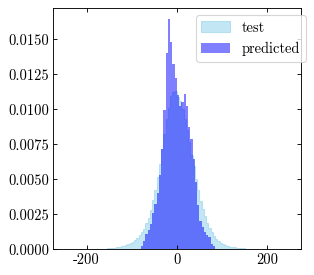

In [45]:
#CombinedModel.load_weights(folder_name+'/models_GALAXIA_nonn/' + 'ModelWeights.h5')
test_preds_2 = CombinedModel.predict(X_test)
y_low = -250
y_high = 250
#here is where I want to rescale test_preds_2[:,0]
test_preds_2[:,0] = (test_preds_2[:,0] * stddev)+mu
test_preds_2[:,1] = (test_preds_2[:,1] * stddev)+mu
#does not work to set = 0 after the fact. 
#for elem_i in range(len(test_preds_2[:,0])):
   # if ((test_preds_2[elem_i,0] >= -10) and (test_preds_2[elem_i,0] <= 10)):
      #  test_preds_2[elem_i, 0] = 0

print(test_preds_2[:,0].shape)
high_err = test_preds_2[:,0] + test_preds_2[:,1]
print(high_err.shape)
low_err = test_preds_2[:,0] - test_preds_2[:,1]
test_preds_hist = np.histogram(test_preds_2[:,0], bins=100, range=(y_low,y_high), density= True)
test_err_hist = np.histogram(test_preds_2[:,1], bins=100, range=(y_low,y_high), density= True)
high_err_hist = np.histogram(high_err, bins=100, range=(y_low,y_high), density= True)
low_err_hist = np.histogram(low_err, bins=100, range=(y_low,y_high), density= True)
conv1 = np.convolve(test_preds_hist[0], high_err_hist[0],'same')
conv2 = np.convolve(high_err_hist[0], low_err_hist[0], 'same')
conv3 = np.convolve(test_preds_hist[0], low_err_hist[0], 'same')
conv4 = np.convolve(test_preds_hist[0],test_err_hist[0],'same')
plt.hist((data_test['radial_velocity']).values, bins=100, range=(y_low,y_high), histtype='step', edgecolor = 'skyblue', color= 'skyblue', fill = True, density = True, label = 'test' , zorder = 0, alpha = 0.5)
#plt.hist(low_err, bins=100, range=(y_low,y_high), density= True, alpha = 0.5)
#plt.hist(high_err, bins=100, range=(y_low,y_high), density= True,alpha = 0.5)
plt.hist(test_preds_2[:,0], bins=100, range=(y_low,y_high), density= True,alpha = 0.5, color = 'blue', label = 'predicted')
#plt.hist(test_preds_2[:,1], bins=100, range=(0,100), density= True)
#plt.figure()
#plt.plot(conv2, label = 'conv2')
#plt.plot(conv1,label = 'conv1')
#plt.plot(conv3,label = 'conv3')
#plt.plot(conv4,label = 'conv4')
#perhpas conv 2 gives errors on histogram bins
plt.legend(bbox_to_anchor=(1.05, 1))
print(conv1.shape)

In [ ]:
plt.figure()
plt.hist((data_test['radial_velocity']).values, bins=100, range=(y_low,y_high), histtype='step', color= 'blue', label = 'test', density = True, alpha = 0.5)
num, binss, _ = plt.hist(test_preds_2[:,0], bins=100, range=(y_low,y_high), histtype='step',color = 'green',  label = 'predicted', density = True, alpha = 0.5)
mid = 0.5*(binss[1:] + binss[:-1])
print(mid.shape)
#plt.errorbar(mid, num,yerr = conv2, fmt='.',color = 'blue', label = 'predicted')
plt.fill_between(mid[0:50],num[0:50]-conv3[0:50],num[0:50]+conv3[0:50] ,label = 'error from conv',color = 'red', zorder = 10, alpha = 0.5)
plt.fill_between(mid[49:100],num[49:100]-conv1[49:100],num[49:100]+conv1[49:100] ,color = 'red', zorder = 10, alpha = 0.5)

#plt.fill_between(mid,num-conv1,num+conv1 ,label = 'error',color = 'red', zorder = 10, alpha = 0.5)
#capsize=3
plt.xlabel('Vr')
plt.ylabel('Stars')
plt.title('Test set - simulated data')
#plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [46]:
#going to consider low error points those with error <= 50 km/s
#test_preds_70 = np.delete(test_preds_2, np.where(test_preds_2[:,1]>=70)[0], 0)
#print(test_preds_70.shape)
test_preds_50 = np.delete(test_preds_2, np.where(test_preds_2[:,1]>=50)[0], 0)
print(test_preds_50.shape)
test_preds_45 = np.delete(test_preds_2, np.where(test_preds_2[:,1]>=45)[0], 0)
print(test_preds_45.shape)
test_preds_40 = np.delete(test_preds_2, np.where(test_preds_2[:,1]>=40)[0], 0)
print(test_preds_40.shape)
test_preds_35 = np.delete(test_preds_2, np.where(test_preds_2[:,1]>=35)[0], 0)
print(test_preds_35.shape)
test_preds_25 = np.delete(test_preds_2, np.where(test_preds_2[:,1]>=25)[0], 0)
print(test_preds_25.shape)
test_preds_18 = np.delete(test_preds_2, np.where(test_preds_2[:,1]>=18)[0], 0)
print(test_preds_18.shape)
test_preds_22 = np.delete(test_preds_2, np.where(test_preds_2[:,1]>=22)[0], 0)
print(test_preds_22.shape)
test_preds_20 = np.delete(test_preds_2, np.where(test_preds_2[:,1]>=20)[0], 0)
print(test_preds_20.shape)
test_preds_30 = np.delete(test_preds_2, np.where(test_preds_2[:,1]>=30)[0], 0)
print(test_preds_30.shape)
test_preds_32 = np.delete(test_preds_2, np.where(test_preds_2[:,1]>=32)[0], 0)
print(test_preds_32.shape)
test_preds_27 = np.delete(test_preds_2, np.where(test_preds_2[:,1]>=27)[0], 0)
print(test_preds_27.shape)

(493816, 2)
(424777, 2)
(237143, 2)
(38822, 2)
(43, 2)
(0, 2)
(2, 2)
(0, 2)
(2267, 2)
(7654, 2)
(243, 2)


In [47]:
def save_indices(thresh):
    if thresh >= 80:
        list_err_gt = []   
        list_err_gt = [(data_test['radial_velocity']).values[i] for i in range(len(test_preds_2[:,1])) if test_preds_2[i,1] > thresh]
        print(len(list_err_gt))
        #now need indices of these values in data
        indices = []
        for i in range(len(list_err_gt)):
            indices.append(data_test[data_test['radial_velocity']==(list_err_gt[i])].index[0])
        np.save(folder_name+'/data_indices_error_gt_'+str(thresh),indices)
    else:
        print('less')
        list_err_lt = []   
        list_err_lt = [(data_test['radial_velocity']).values[i] for i in range(len(test_preds_2[:,1])) if test_preds_2[i,1] < thresh]
        print(len(list_err_lt))
        #now need indices of these values in data
        indices = []
        for i in range(len(list_err_lt)):
            indices.append(data_test[data_test['radial_velocity']==(list_err_lt[i])].index[0])
        np.save(folder_name+'/data_indices_error_lt_'+str(thresh),indices)
        

In [52]:
save_indices(20)

less
392


In [48]:
thresholds = [35,30]
for thresh_i in thresholds: 
    save_indices(thresh_i)

less
38822
less
2267


In [49]:
from scipy.stats import ks_2samp
from scipy.stats import kstest
from scipy.stats import f

In [50]:
def gaussian(x,mu,sigma):
    prefactor = 1/(np.sqrt(2*np.pi)*sigma)
    return prefactor*np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma))



## Going to use Monte Carlo simulations to predict errorbars. 

In [51]:
def monte_carlo(df, test_preds_cut, thresh):  
    from matplotlib.colors import LogNorm
    mc_vr_pred_list = []
    resample_test_list = []
    bin_values_list = []
    min_array = []
    max_array = []
    min_array_r = []
    max_array_r = []
    min_array_th = []
    max_array_th = []
    min_array_phi = []
    max_array_phi = []

    data_test = reload_data_per_cut(thresh)
    hb_list = []
    hb_list_r = []
    hb_list_th = []
    hb_list_phi = []
    hex_centers = []
    
    bin_values_list_r = []
    bin_values_list_th = []
    bin_values_list_phi = []
    
    p_vals_list = []
    cdf_mc_list = []
    gaussian_array = np.zeros(50)
    N = len((data_test['radial_velocity']).values)
    x_range = np.linspace(y_low,y_high,N)
    for mc_i in range(0,100):
        mc_vr_pred = []
        resample_test = []
        for star_i in range(0,len(test_preds_cut)):
            #mc_vr_pred.append(np.mean([np.random.normal(test_preds_2[star_i,0],test_preds_2[star_i,1]) for _ in range(1000)]))
            mc_vr_pred.append(np.random.normal(test_preds_cut[star_i,0],test_preds_cut[star_i,1]))
            resample_test.append(np.random.normal((data_test['radial_velocity']).values[star_i],0))
            #if mc_i == 0: 
                #gauss = gaussian(x_range,test_preds_cut[star_i,0],test_preds_cut[star_i,1] )
                ##print(gauss)
               # n_gauss_hist , bins_gauss_hist= np.histogram(gauss, bins=50, range=(y_low,y_high))
                #gaussian_array = gaussian_array + n_gauss_hist
        mc_vr_pred_list.append(mc_vr_pred)
        resample_test_list.append(resample_test)
        n, bins = np.histogram(mc_vr_pred,bins=50,range=(y_low,y_high))
        n_test_preds, bins_test_preds = np.histogram((data_test['radial_velocity']).values, bins=50, range=(y_low,y_high))
        cdf = np.cumsum(n_test_preds)
        cdf_mc_list.append(np.cumsum(n))
        #x = f.fit(n_test_preds)
        #dfn=x[0]
        #dfd=x[1]
        #fdist = f(dfn, dfd)
        #statistic, pvalue = kstest(n, cdf)
        #statistic, pvalue = ks_2samp(n, n_test_preds)
        #statistic, pvalue = ks_2samp(mc_vr_pred, (data_test['radial_velocity']).values)
        #p_vals_list.append(pvalue)
        
        plt.figure(2)
        hb = plt.hexbin((data_test['radial_velocity']).values, mc_vr_pred,gridsize=100, norm = LogNorm(),extent=[-200, 200, -200, 200]);
        plt.close(2)
        hb_list.append(hb.get_array());
        bin_values_list.append(n)
        
        #now for the coordinate-transformed histograms
        vel_sph_coord = get_coord_transform(data_test, np.array(mc_vr_pred))
        n_r , bins_r = np.histogram(vel_sph_coord[:,0], bins=50, range=(-250,250))
        n_th , bins_th = np.histogram(vel_sph_coord[:,1], bins=50, range=(-250,250))
        n_phi , bins_phi = np.histogram(vel_sph_coord[:,2], bins=50, range=(-450,0))
        bin_values_list_r.append(n_r)
        bin_values_list_th.append(n_th)
        bin_values_list_phi.append(n_phi)
        
        plt.figure(3)
        hb_r = plt.hexbin((data_test['vr']).values, vel_sph_coord[:,0],gridsize=100, norm = LogNorm(),extent=[-250, 250, -250, 250]);
        plt.close(3)
        hb_list_r.append(hb_r.get_array());
        
        plt.figure(4)
        hb_th = plt.hexbin((data_test['vtheta']).values, vel_sph_coord[:,1],gridsize=100, norm = LogNorm(),extent=[-250, 250, -250, 250]);
        plt.close(4)
        hb_list_th.append(hb_th.get_array());
        
        plt.figure(5)
        hb_phi = plt.hexbin((data_test['vphi']).values, vel_sph_coord[:,2],gridsize=100, norm = LogNorm(),extent=[-450, 0, -450, 0]);
        plt.close(5)
        hb_list_phi.append(hb_phi.get_array());
    
    #large_array_test = np.array((data_test['radial_velocity']).values)
    #large_array_test = np.concatenate((large_array_test,large_array_test,large_array_test,large_array_test,large_array_test),axis = None)
    #statistic, pvalue = ks_2samp(np.array(mc_vr_pred_list).flatten(), large_array_test)    
    #p_vals_list.append(pvalue)
   # print(np.shape(gaussian_array))
   # kde = gaussian_array/ (50*100 *(500/20))
   # print(kde)
    median_mc_each_star = np.median(mc_vr_pred_list, axis = 0)
    #print(median_mc_each_star)
    
    bin_values_list_arr = np.array(bin_values_list)    
    max_array = bin_values_list_arr.max(axis=0)
    median_array = np.median(bin_values_list_arr,axis=0)
    min_array = bin_values_list_arr.min(axis=0) 
    
    bin_values_list_r_arr = np.array(bin_values_list_r)    
    max_array_r = bin_values_list_r_arr.max(axis=0)
    min_array_r = bin_values_list_r_arr.min(axis=0) 
    
    bin_values_list_th_arr = np.array(bin_values_list_th)    
    max_array_th = bin_values_list_th_arr.max(axis=0)
    min_array_th = bin_values_list_th_arr.min(axis=0) 
    
    bin_values_list_phi_arr = np.array(bin_values_list_phi)    
    max_array_phi = bin_values_list_phi_arr.max(axis=0)
    min_array_phi = bin_values_list_phi_arr.min(axis=0) 

    return min_array, max_array,median_array, hb_list, hb_list_r,hb_list_th,hb_list_phi, min_array_r,max_array_r,min_array_th,max_array_th, min_array_phi,max_array_phi, mc_vr_pred_list,cdf_mc_list, median_mc_each_star, resample_test_list


In [ ]:
plot_test(22)

In [52]:
import TransformCoords
def get_coord_transform(df, train_preds):
    #needs only vr values of train_preds (maybe...need to see what to do about error)
    # m12i
    # v_LSR = [224.7092,-20.3801, 3.8954]
    # r_LSR = [0,8.2,0]
    # Galaxia
    v_LSR = [11.1, 239.08, 7.25]
    r_LSR = [-8.,0.,0.015]
    inds = np.arange(df.shape[0])
    inds_train = np.arange(df.shape[0])
    sub_num = df.shape[0]
    vels_sph = np.array([df['vr'].values[inds][:sub_num],df['vtheta'].values[inds][:sub_num],df['vphi'].values[inds][:sub_num]]).T
    coords_cart = np.array([df['x'].values[inds][:sub_num],df['y'].values[inds][:sub_num],df['z'].values[inds][:sub_num]]).T
    
    ra_cut = df['ra'].values[inds][:sub_num]
    dec_cut = df['dec'].values[inds][:sub_num]
    parallax_cut = df['parallax'].values[inds][:sub_num]
    pmra_cut = df['pmra'].values[inds][:sub_num]
    pmdec_cut = df['pmdec'].values[inds][:sub_num]
    rv_cut = df['radial_velocity'].values[inds][:sub_num]
    
    U_pred_train,V_pred_train,W_pred_train = TransformCoords.pm2galcart(np.deg2rad(ra_cut[inds_train]),np.deg2rad(dec_cut[inds_train]),parallax_cut[inds_train],pmra_cut[inds_train],pmdec_cut[inds_train],train_preds.flatten().astype('float'))
    
    coords_cart_train = coords_cart[inds_train,:]
    
    vels_cart_pred_train = np.array([U_pred_train+v_LSR[0],V_pred_train+v_LSR[1],W_pred_train+v_LSR[2]]).T
    
    coords_sph_train, vels_sph_pred_train = TransformCoords.rvcart2sph_vec(coords_cart_train,vels_cart_pred_train)
    
    coords_sph_train[:,[1,2]] = coords_sph_train[:,[2,1]] # Swap theta, phi into correct order
    
    vels_sph_pred_train[:,[1,2]] = vels_sph_pred_train[:,[2,1]] # Swap theta, phi into correct order
    
    return vels_sph_pred_train



In [53]:
def reload_data_per_cut(thresh):
    hold = 0
    data_test = np.load('/tigress/ljchang/DataXGaia/data/galaxia_mock/test_set_500k.npz')
    data_test = data_test['data']
    data_cols = ['source_id', 'l', 'b', 'ra', 'dec', 'parallax', 'parallax_error', 
                 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'radial_velocity',
                 'photo_g_mean_mag', 'photo_bp_mean_mag', 'photo_rp_mean_mag',
                 'x','y','z','vx','vy','vz','r','phi','theta','vr','vphi','vtheta']
    data_test = pd.DataFrame(data_test, columns=data_cols)
    print(data_test.shape)
    indices_to_drop = []
    if thresh >= 80:
        indices_to_drop = np.load(folder_name+'/data_indices_error_gt_'+str(thresh)+'.npy')
        print(np.shape(indices_to_drop))
        print('number of indices left '+ str(500000-np.shape(indices_to_drop)[0]))
        print(indices_to_drop[332788:332798])
        indices_to_drop = np.array(indices_to_drop)
        print(indices_to_drop[0:1000])
        print([item for item, count in collections.Counter(indices_to_drop).items() if count > 1])
        #data_test = data_test.loc[indices_to_drop]
        data_test = data_test.drop(data_test.index[indices_to_drop])
        print(data_test.shape)
    elif thresh < 80 and thresh > 0:
        indices_to_drop = np.load(folder_name+'/data_indices_error_lt_'+str(thresh)+'.npy')
        print(np.shape(indices_to_drop))
        print(indices_to_drop[1:10])
        data_test = data_test.loc[indices_to_drop]
        #data_test = data_test.drop(data_test.index[indices_to_drop])
        print('second if '+str(data_test.shape))
    elif thresh == 0: 
        hold = 0
        print('hold = 0')

    #pdiff_test = float(len(np.argwhere((data_test['radial_velocity']).values < 0))/len(np.argwhere((data_test['radial_velocity']).values > 0)))
    #if pdiff_test > 1: data_test.drop(data_test.query('radial_velocity < 0').sample(frac=(pdiff_test-1)).index, inplace = True)
    #pdiffafter_test = float(len(np.argwhere((data_test['radial_velocity']).values < 0))/len(np.argwhere((data_test['radial_velocity']).values > 0)))
    weights_test = np.ones(data_test.shape[0])
    return data_test

In [56]:
 def plot_test(thresh): 
    data_test = reload_data_per_cut(thresh)
    print('shape of data_test is '+str(data_test.shape))
    if thresh == 0: test_preds = test_preds_2
    elif thresh == 50: test_preds = test_preds_50
    elif thresh == 45: test_preds = test_preds_45
    elif thresh == 40: test_preds = test_preds_40
    elif thresh == 30: test_preds = test_preds_30
    elif thresh == 35: test_preds = test_preds_35
    elif thresh == 25: test_preds = test_preds_25
    elif thresh == 20: test_preds = test_preds_20
    elif thresh == 22: test_preds = test_preds_22
    elif thresh == 27: test_preds = test_preds_27
    elif thresh == 18: test_preds = test_preds_18
    y_low = -250
    y_high = 250
    plt.figure(figsize=(12, 28))
    gs0 = gridspec.GridSpec(7, 3, hspace=0.3, wspace=0.3)

    from matplotlib.colors import LogNorm
    plt.subplot(gs0[3], label = '3')
    plt.hist2d(test_preds[:,1],test_preds[:,0], bins=40,norm = LogNorm())
    clb1 = plt.colorbar()
    clb1.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel('$\sigma$',labelpad=-5)
    

    plt.subplot(gs0[2], label = '2')
    hb = plt.hexbin((data_test['radial_velocity']).values, test_preds[:,0],gridsize=100, norm = LogNorm(),extent=[-200, 200, -200, 200])
    #x1 = np.linspace(np.min((data_test_scaled['radial_velocity']).values),np.max((data_test_scaled['radial_velocity']).values),1000)
    x1 = np.linspace(-150,150,1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel(r'$v_{\rm{los}}^{\rm{meas}}$')
    clb3 = plt.colorbar(hb)
    clb3.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)


    plt.subplot(gs0[5], label = '5')
    plt.hist2d((data_test['l']).values,test_preds[:,0], bins=40,norm = LogNorm())
    clb4 = plt.colorbar()
    clb4.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.plot(x1,y1,'k--')
    plt.xlabel(r'$l$',labelpad=-3)
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred}}$',labelpad=-5)


    plt.subplot(gs0[6], label = '6')
    dist_hist = np.divide(np.ones_like((data_test['parallax']).values),(data_test['parallax']).values)
    plt.hist2d(dist_hist, test_preds[:,1], bins=40, norm = LogNorm())
    clb5 = plt.colorbar()
    clb5.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.xlabel('Distance (kpc)',fontsize = 12)
    plt.ylabel('$\sigma$',labelpad=-5)

    plt.subplot(gs0[1], label = '1')
    plotrange = np.linspace(-5,5,1000)
    diff_hist = np.divide(np.subtract(test_preds[:,0],(data_test['radial_velocity']).values),test_preds[:,1])
    mean_diffs, mean_stds = np.mean(diff_hist), np.std(diff_hist)
    plt.hist(diff_hist,bins=20, range=(-5,5), histtype='bar',ec = 'white', color = 'tab:blue',alpha = 0.5,fill = True, density = True)
    plt.plot(plotrange, norm.pdf(plotrange, mean_diffs, mean_stds),color = 'darkorange', linestyle = '--', linewidth = 2.5,label = 'normal fit')
    plt.yscale('log')
    plt.legend(loc = "upper right",prop={'size': 8})
    plt.xlabel(r'$(v_{\rm{los}}^{\rm{pred}} - v_{\rm{los}}^{\rm{meas}})/\sigma$',labelpad=-5)
    
    plt.subplot(gs0[4], label = '4')
    plt.hist2d((data_test['l']).values,test_preds[:,1], bins=40,norm = LogNorm())
    clb2 = plt.colorbar()
    clb2.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    plt.plot(x1,y1,'k--')
    plt.xlabel(r'$l$',labelpad=-3)
    plt.ylabel('$\sigma$',labelpad=-5)
    

    plt.subplot(gs0[0], label = '0')
    plt.hist((data_test['radial_velocity']).values, bins=50, range=(y_low,y_high), histtype='bar', edgecolor = 'white', color= 'tab:blue',alpha = 0.5, fill = True, label = 'test', density = True )
    plt.hist(test_preds[:,0], bins=100, range=(y_low,y_high), histtype='step',color = 'darkslateblue', linewidth = 1.3, label = 'predicted', density = True)
    plt.xlabel(r'$v_{\rm{los}}$', labelpad =-2)
    if thresh == 0: plt.title('Test set, 100 bins, no sigma cut, '+str(len(test_preds[:,0]))+' stars',fontsize=14)
    if thresh != 0: plt.title('Test set, $\sigma \leq$'+str(thresh)+' km/s, '+str(len(test_preds[:,0]))+' stars',fontsize=14)
    #plt.yscale('log')
    plt.legend(loc = "upper right",prop={'size': 10})
    
    
    plt.subplot(gs0[7], label = '7')
    hist_test, bins_test, patches_test = plt.hist((data_test['radial_velocity']).values, bins=50, range=(y_low,y_high), histtype='bar', edgecolor = 'white', color= 'tab:blue', alpha = 0.5, fill = True, label = 'test' , zorder = 0)
    bin_centers_test = (bins_test[1:]+bins_test[:-1])/2
    min_array, max_array,median_array, hb_list, hb_list_r,hb_list_th,hb_list_phi, min_array_r,max_array_r,min_array_th,max_array_th, min_array_phi,max_array_phi, mc_vr_pred_list,cdf_mc_list, median_mc_each_star,resample_test_list= monte_carlo(data_test, test_preds, thresh);
    plt.fill_between(bin_centers_test,min_array, max_array,label = 'MC spread',color = 'orange', zorder = 10, alpha = 0.5)
    plt.plot(bin_centers_test,median_array, color = 'red',linewidth = 1.3, label = 'MC med', zorder = 30 )
    plt.hist(test_preds[:,0], bins=50, range=(y_low,y_high), histtype='step',color = 'darkslateblue',linewidth = 1.3, label = 'predicted', zorder = 20)
    plt.xlabel(r'$v_{\rm{los}}$')
    plt.legend(loc = "upper right",prop={'size': 10})
    
    plt.subplot(gs0[8], label = '8')
    hb_mean=plt.hexbin((data_test['radial_velocity']).values, np.zeros_like((data_test['radial_velocity']).values),gridsize=100, norm = LogNorm(),extent=[-200, 200, -200, 200])
    hb_mean.set_array(np.mean(hb_list, axis = 0))
    x1 = np.linspace(-150,150,1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.ylabel(r'$v_{\rm{los}}^{\rm{pred, MC}}$',labelpad=-10)
    plt.xlabel(r'$v_{\rm{los}}^{\rm{meas}}$')
    plt.clim(1,(np.max(hb_list)/2)*1.5)
    clb6 = plt.colorbar(hb_mean)
    clb6.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    
    vels_sph_pred_test = get_coord_transform(data_test, test_preds)
    #'vr','vphi','vtheta'
    plt.subplot(gs0[9], label = '9')
    hb_r = plt.hexbin((data_test['vr']).values, vels_sph_pred_test[:,0],gridsize=100, norm = LogNorm(),extent=[-250, 250, -250, 250])
    x1 = np.linspace(-250,250,1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.ylabel(r'$v_{\rm{r}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel(r'$v_{\rm{r}}^{\rm{meas}}$')
    clb7 = plt.colorbar(hb_r)
    clb7.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    
    plt.subplot(gs0[10], label = '10')
    hb_t = plt.hexbin((data_test['vtheta']).values, vels_sph_pred_test[:,1],gridsize=100, norm = LogNorm(),extent=[-250, 250, -250, 250])
    x2 = np.linspace(-250,250,1000)
    y2 = x2
    plt.plot(x2,y2,'k--')
    plt.ylabel(r'$v_{\rm{\theta}}^{\rm{pred}}$',labelpad=-10)
    plt.xlabel(r'$v_{\rm{\theta}}^{\rm{meas}}$')
    clb8 = plt.colorbar(hb_t)
    clb8.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    
    plt.subplot(gs0[11], label = '11')
    hb_p = plt.hexbin((data_test['vphi']).values, vels_sph_pred_test[:,2],gridsize=100, norm = LogNorm(),extent=[-450, 0, -450, 0])
    x3 = np.linspace(-450,0,1000)
    y3 = x3
    plt.plot(x3,y3,'k--')
    plt.ylabel(r'$v_{\rm{\phi}}^{\rm{pred}}$',labelpad=-5)
    plt.xlabel(r'$v_{\rm{\phi}}^{\rm{meas}}$')
    clb9 = plt.colorbar(hb_p)
    clb9.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    
    plt.subplot(gs0[12], label = '12')
    hist_test_r, bins_test_r, patches_test_r = plt.hist((data_test['vr']).values, bins=50, range=(y_low,y_high), histtype='bar', edgecolor = 'white', color= 'tab:blue',alpha = 0.5, fill = True,  label = 'test' )
    bin_centers_test_r = (bins_test_r[1:]+bins_test_r[:-1])/2
    plt.fill_between(bin_centers_test_r,min_array_r, max_array_r,label = 'MC spread',color = 'orange',alpha = 0.5)
    plt.hist(vels_sph_pred_test[:,0], bins=50, range=(y_low,y_high), histtype='step',color = 'darkslateblue', linewidth = 1.3,label = 'predicted')
    plt.xlabel(r'$v_{\rm{r}}$', labelpad =-2)
    plt.legend(loc = "upper right",prop={'size': 10})
    
    plt.subplot(gs0[13], label = '13')
    hist_test_th, bins_test_th, patches_test_th = plt.hist((data_test['vtheta']).values, bins=50, range=(y_low,y_high), histtype='bar', edgecolor = 'white', color= 'tab:blue',alpha = 0.5,fill = True, label = 'test', zorder = 0)
    bin_centers_test_th = (bins_test_th[1:]+bins_test_th[:-1])/2
    plt.fill_between(bin_centers_test_th,min_array_th, max_array_th,label = 'MC spread',color = 'orange', alpha = 0.5, zorder = 10)
    plt.hist(vels_sph_pred_test[:,1], bins=50, range=(y_low,y_high), histtype='step',color = 'darkslateblue',linewidth = 1.3, label = 'predicted', zorder = 20)
    plt.xlabel(r'$v_{\rm{\theta}}$', labelpad =-2)
    plt.legend(loc = "upper right",prop={'size': 10})
    
    plt.subplot(gs0[14], label = '14')
    hist_test_phi, bins_test_phi, patches_test_phi = plt.hist((data_test['vphi']).values, bins=50, range=(-450,0), histtype='bar', edgecolor = 'white', color= 'tab:blue', alpha = 0.5,fill = True,  label = 'test', zorder = 0)
    bin_centers_test_phi = (bins_test_phi[1:]+bins_test_phi[:-1])/2
    plt.fill_between(bin_centers_test_phi,min_array_phi, max_array_phi,label = 'MC spread',color = 'orange', alpha = 0.5, zorder = 10)
    plt.hist(vels_sph_pred_test[:,2], bins=50, range=(-450,0), histtype='step',color = 'darkslateblue', linewidth = 1.3,label = 'predicted', zorder = 20)
    plt.xlabel(r'$v_{\rm{\phi}}$', labelpad =-2)
    plt.legend(loc = "upper right",prop={'size': 10})
    
    plt.subplot(gs0[15], label = '15')
    hb_mean_r=plt.hexbin((data_test['vr']).values, np.zeros_like((data_test['vr']).values), gridsize=100, norm = LogNorm(),extent=[-250, 250, -250, 250])
    hb_mean_r.set_array(np.mean(hb_list_r, axis = 0))
    x1 = np.linspace(-250,250,1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.ylabel(r'$v_{\rm{r}}^{\rm{pred, MC}}$',labelpad=-10)
    plt.xlabel(r'$v_{\rm{r}}^{\rm{meas}}$')
    plt.clim(1,(np.max(hb_list_r)/2)*1.5)
    clb10 = plt.colorbar(hb_mean_r)
    clb10.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    
    plt.subplot(gs0[16], label = '16')
    hb_mean_th=plt.hexbin((data_test['vtheta']).values, np.zeros_like((data_test['vtheta']).values), gridsize=100, norm = LogNorm(),extent=[-250, 250, -250, 250])
    hb_mean_th.set_array(np.mean(hb_list_th, axis = 0))
    x1 = np.linspace(-250,250,1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.ylabel(r'$v_{\rm{\theta}}^{\rm{pred, MC}}$',labelpad=-10)
    plt.xlabel(r'$v_{\rm{\theta}}^{\rm{meas}}$')
    plt.clim(1,(np.max(hb_list_th)/2)*1.5)
    clb11 = plt.colorbar(hb_mean_th)
    clb11.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    
    plt.subplot(gs0[17], label = '17')
    hb_mean_phi=plt.hexbin((data_test['vphi']).values, np.zeros_like((data_test['vphi']).values), gridsize=100, norm = LogNorm(),extent=[-450, 0, -450, 0])
    hb_mean_phi.set_array(np.mean(hb_list_phi, axis = 0))
    x1 = np.linspace(-450,0,1000)
    y1 = x1
    plt.plot(x1,y1,'k--')
    plt.ylabel(r'$v_{\rm{\phi}}^{\rm{pred, MC}}$',labelpad=-10)
    plt.xlabel(r'$v_{\rm{\phi}}^{\rm{meas}}$')
    plt.clim(1,(np.max(hb_list_phi)/2)*1.5)
    clb12 = plt.colorbar(hb_mean_phi)
    clb12.set_label('Density', labelpad=-25, y=1.08, rotation=0,fontsize=10)
    
    plt.subplot(gs0[18], label = '18')
    #stat_vals_list = []
    p_vals_list = []
    p_vals_test_list = []
    for j in range(0,100):
        for k in range(j,100):
            if j == k: continue;
            statistic, pvalue = ks_2samp(mc_vr_pred_list[j], mc_vr_pred_list[k])
            #stat_vals_list.append(statistic)
            p_vals_list.append(pvalue)
        statistic_test , pvalue_test = ks_2samp(resample_test_list[j], (data_test['radial_velocity']).values)
        p_vals_test_list.append(pvalue_test)
    hist_test_ks, bins_test_ks, patches_test_ks = plt.hist(p_vals_list,histtype='bar', edgecolor = 'white', color= 'tab:blue', alpha = 0.5,fill = True)
    plt.xlabel('$v_{los}$: KS(100 MCs,100 MCs)')
    #print(len(stat_vals_list))
    
    plt.subplot(gs0[19], label = '19')
    #from scipy.special import kolmogorov
    #p_values = 1 - kolmogorov(np.array(stat_vals_list)*np.sqrt(len((data_test['radial_velocity']).values)))
    plt.hist(p_vals_test_list,histtype='bar', edgecolor = 'white', color= 'tab:blue', alpha = 0.5,fill = True)
    plt.xlabel('KS(100 resamples,$v_{los}^{truth}$)')
    #stat_mu, p_val_mu = ks_2samp(median_mc_each_star,test_preds[:,0])
    #plt.title()
    #plt.xlabel('pvalues calculated from KS statistic')
    
    #plt.subplot(gs0[20], label = '20')
    
    plt.subplot(gs0[20], label = '20')
    #n_test_preds, bins_test_preds = np.histogram((data_test['radial_velocity']).values, bins=50, range=(y_low,y_high))
    #cdf = np.cumsum(n_test_preds)
    #plt.plot(bins_test_preds[1:], cdf/cdf[-1])
    #plt.xlabel('CDFs of '+r'$v_{\rm{los}}^{\rm{meas}}$'+'and all '+r'$v_{\rm{los}}^{\rm{pred, MC}}$')
    #plt.plot(bins_test_preds[1:], np.array(cdf_mc_list).flatten()/np.array(cdf_mc_list).flatten()[-1])
    #for i in range(0,100):
    #    import random
    #    r = random.random()
    #    b = random.random()
    #    g = random.random()
    #    color = (r, g, b)
    #    plt.plot(bins_test_preds[1:], cdf_mc_list[i]/cdf_mc_list[i][-1], c = color)
        
    #f, ax = plt.subplots(0,0)
    stat_test_mu, pval_test_mu = ks_2samp(test_preds[:,0],(data_test['radial_velocity']).values)
    t_1 = ('KS($v_{los}^{pred}$, $v_{los}^{truth}$) = '+str(round(pval_test_mu,4)))
    
    stat_test, p_val_test = ks_2samp(median_mc_each_star,(data_test['radial_velocity']).values)
    t_2 = ('KS(median of MC trials, $v_{los}^{truth}$) = '+str(round(p_val_test,4)))
    
    stat_mu, p_val_mu = ks_2samp(median_mc_each_star,test_preds[:,0])
    t_3 = ('KS(median of MC trials, $v_{los}^{pred}$) = '+str(round(p_val_mu,4)))
    
    t_4 = ('input vars = '+ str(use_cols))
    t_5 = (neurons+' '+num_samp+' '+act_func+' '+dropout+' '+lweights+' '+spec)
    
    plt.text(0, 0.8, t_1,  rotation=0)
    plt.text(0, 0.6, t_2,  rotation=0) 
    plt.text(0, 0.4, t_3,  rotation=0) 
    plt.text(0,0.3, t_4, wrap= True)
    plt.text(0,0.2, t_5, wrap= True)
    
    plt.savefig(folder_name+'/'+filename+'_withKSnew_sigmaleq_'+str(thresh)+'.png')
    #np.save(folder_name+'/'+filename+'_testpreds_sigmaleq_'+str(thresh)+'.npy',test_preds)
    clb1.remove()
    clb2.remove()
    clb3.remove()
    clb4.remove()
    clb5.remove()
    clb6.remove()
    clb7.remove()
    clb8.remove()
    clb9.remove()
    clb10.remove()
    clb11.remove()
    clb12.remove()
    

(500000, 27)
hold = 0
shape of data_test is (500000, 27)
(500000, 27)
hold = 0


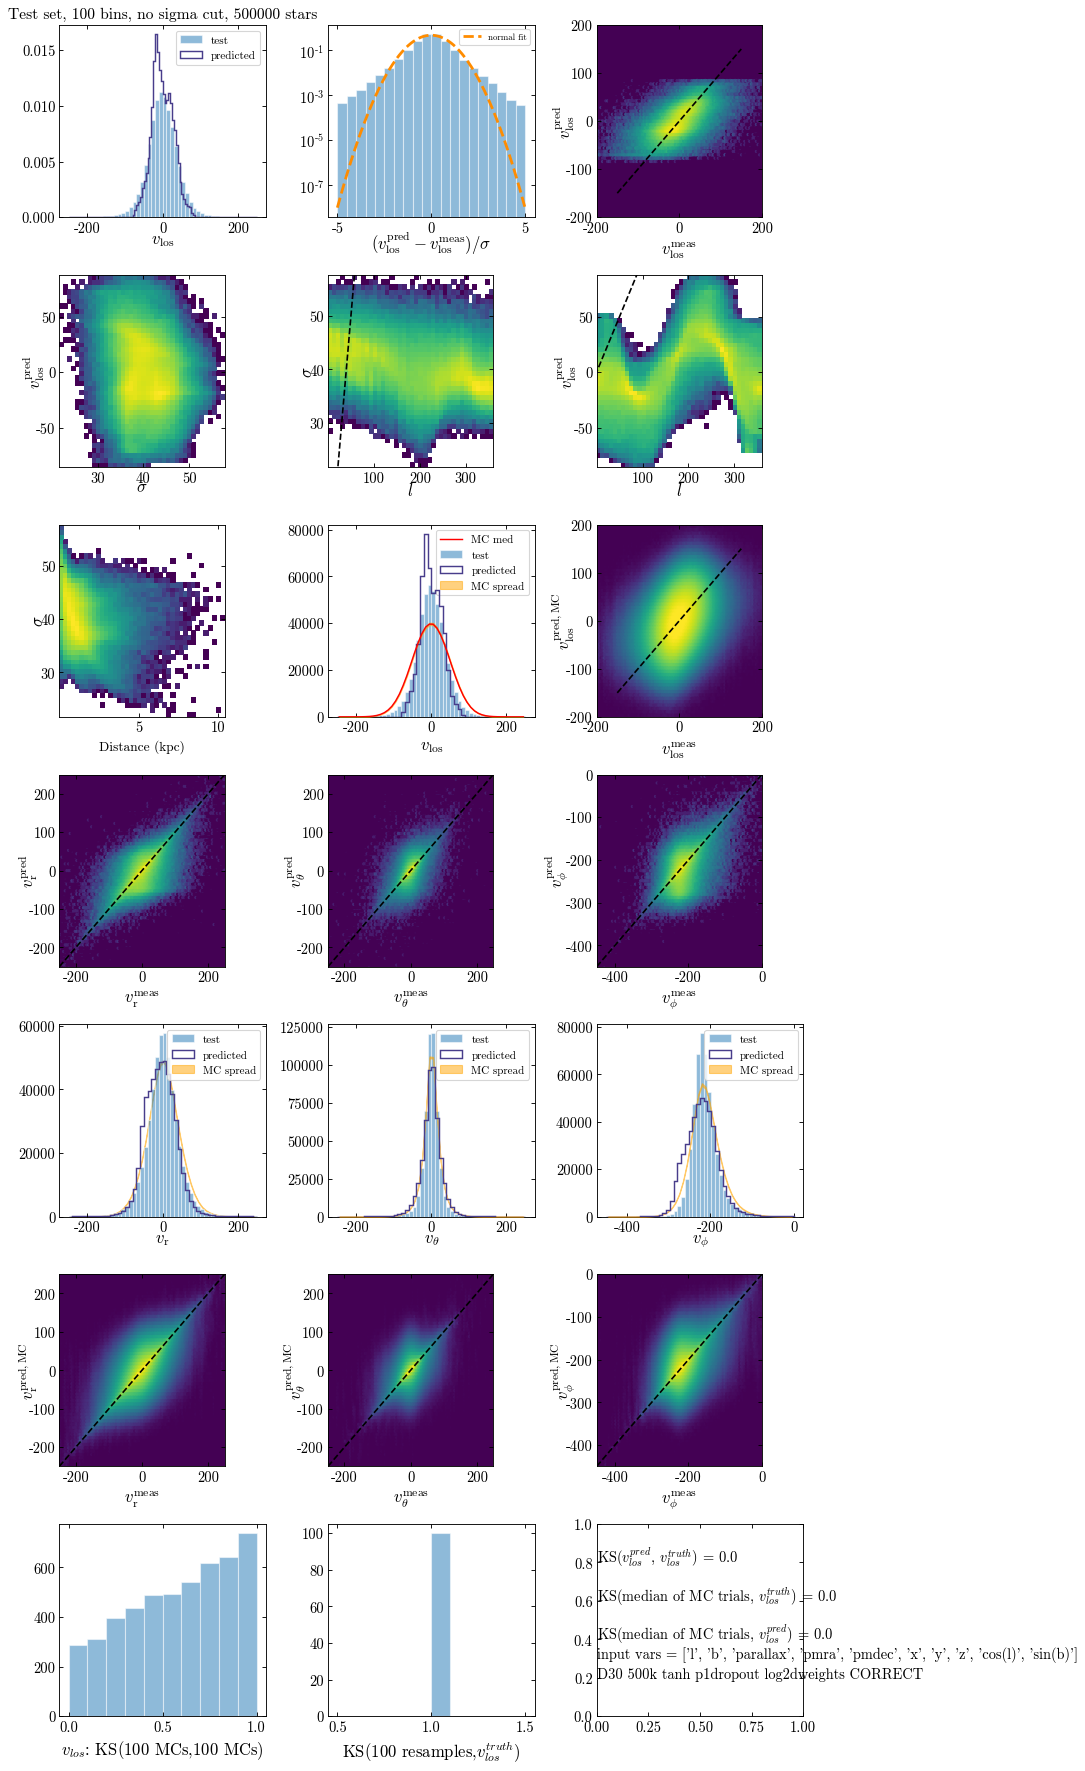

In [57]:
plot_test(0)

(500000, 27)
(2267,)
[ 857 1051 1098 1139 1193 1516 1789 1854 2223]
second if (2267, 27)
shape of data_test is (2267, 27)
(500000, 27)
(2267,)
[ 857 1051 1098 1139 1193 1516 1789 1854 2223]
second if (2267, 27)


Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


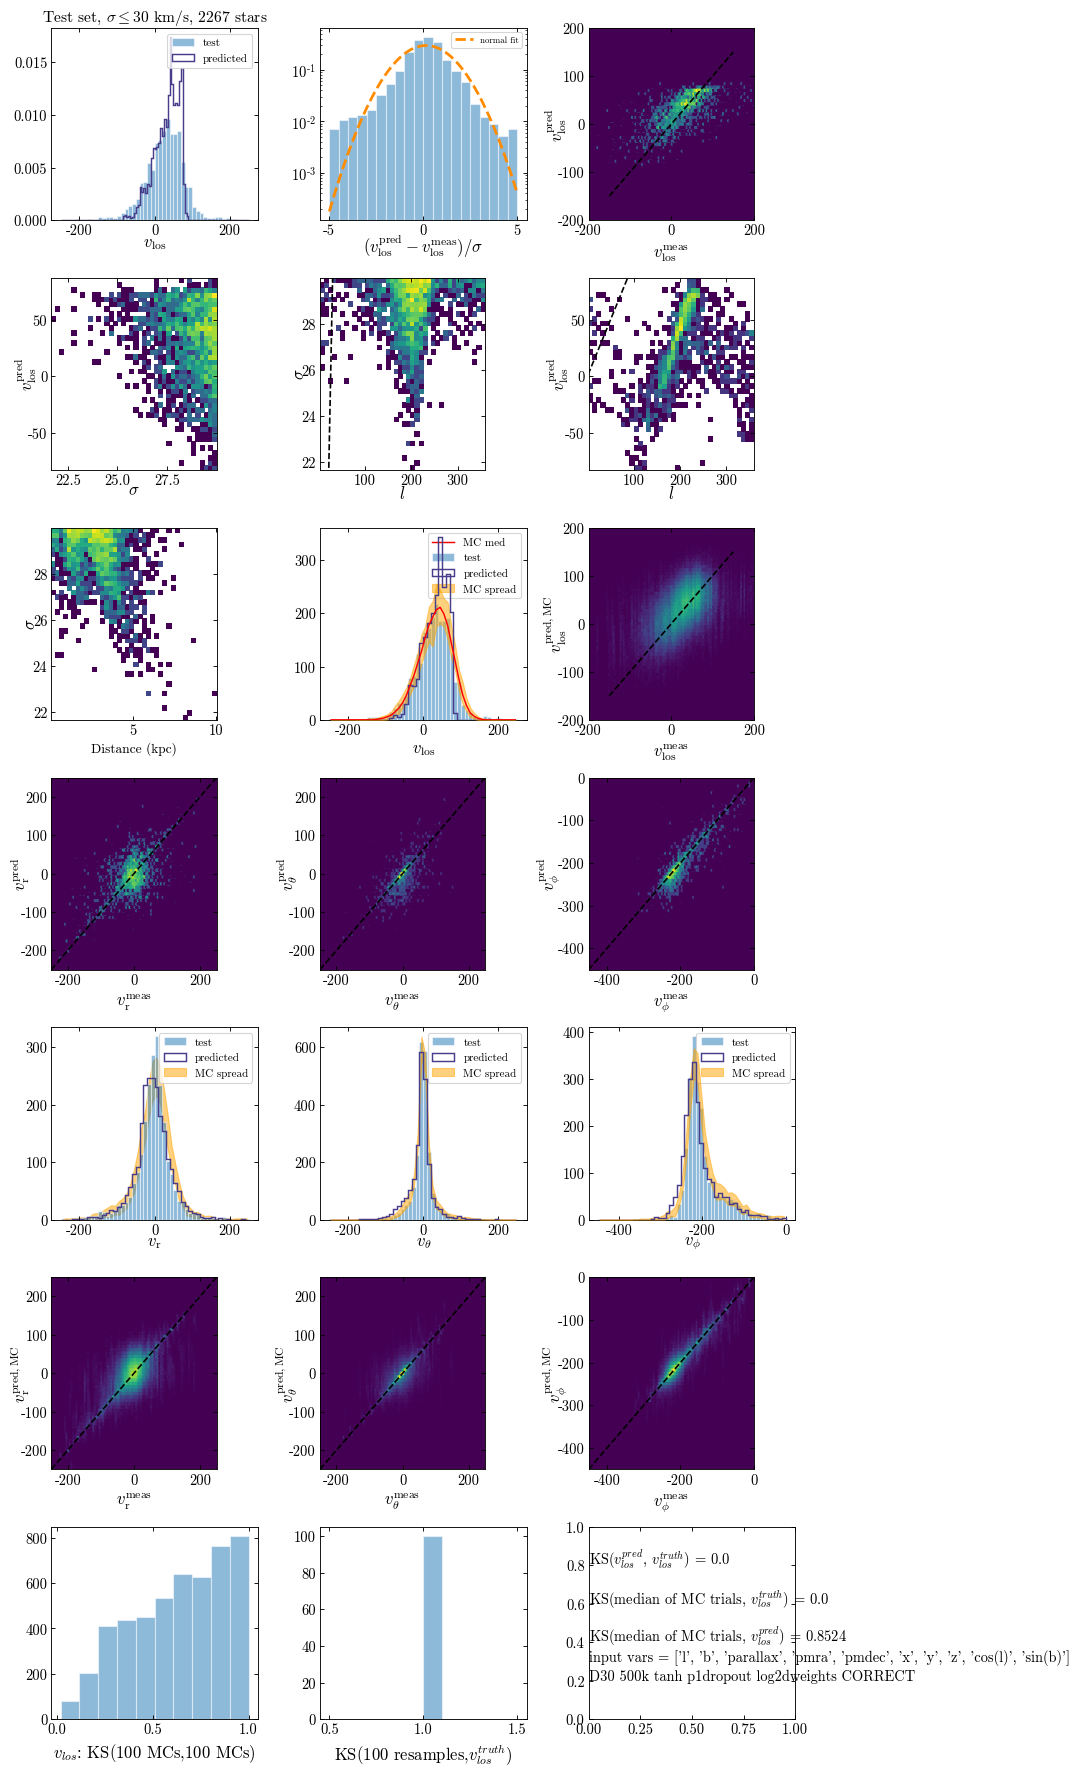

In [58]:
plot_test(30)

(500000, 27)
(38822,)
[ 54  61  63  76  87  89  94 101 104]
second if (38822, 27)
shape of data_test is (38822, 27)
(500000, 27)
(38822,)
[ 54  61  63  76  87  89  94 101 104]
second if (38822, 27)


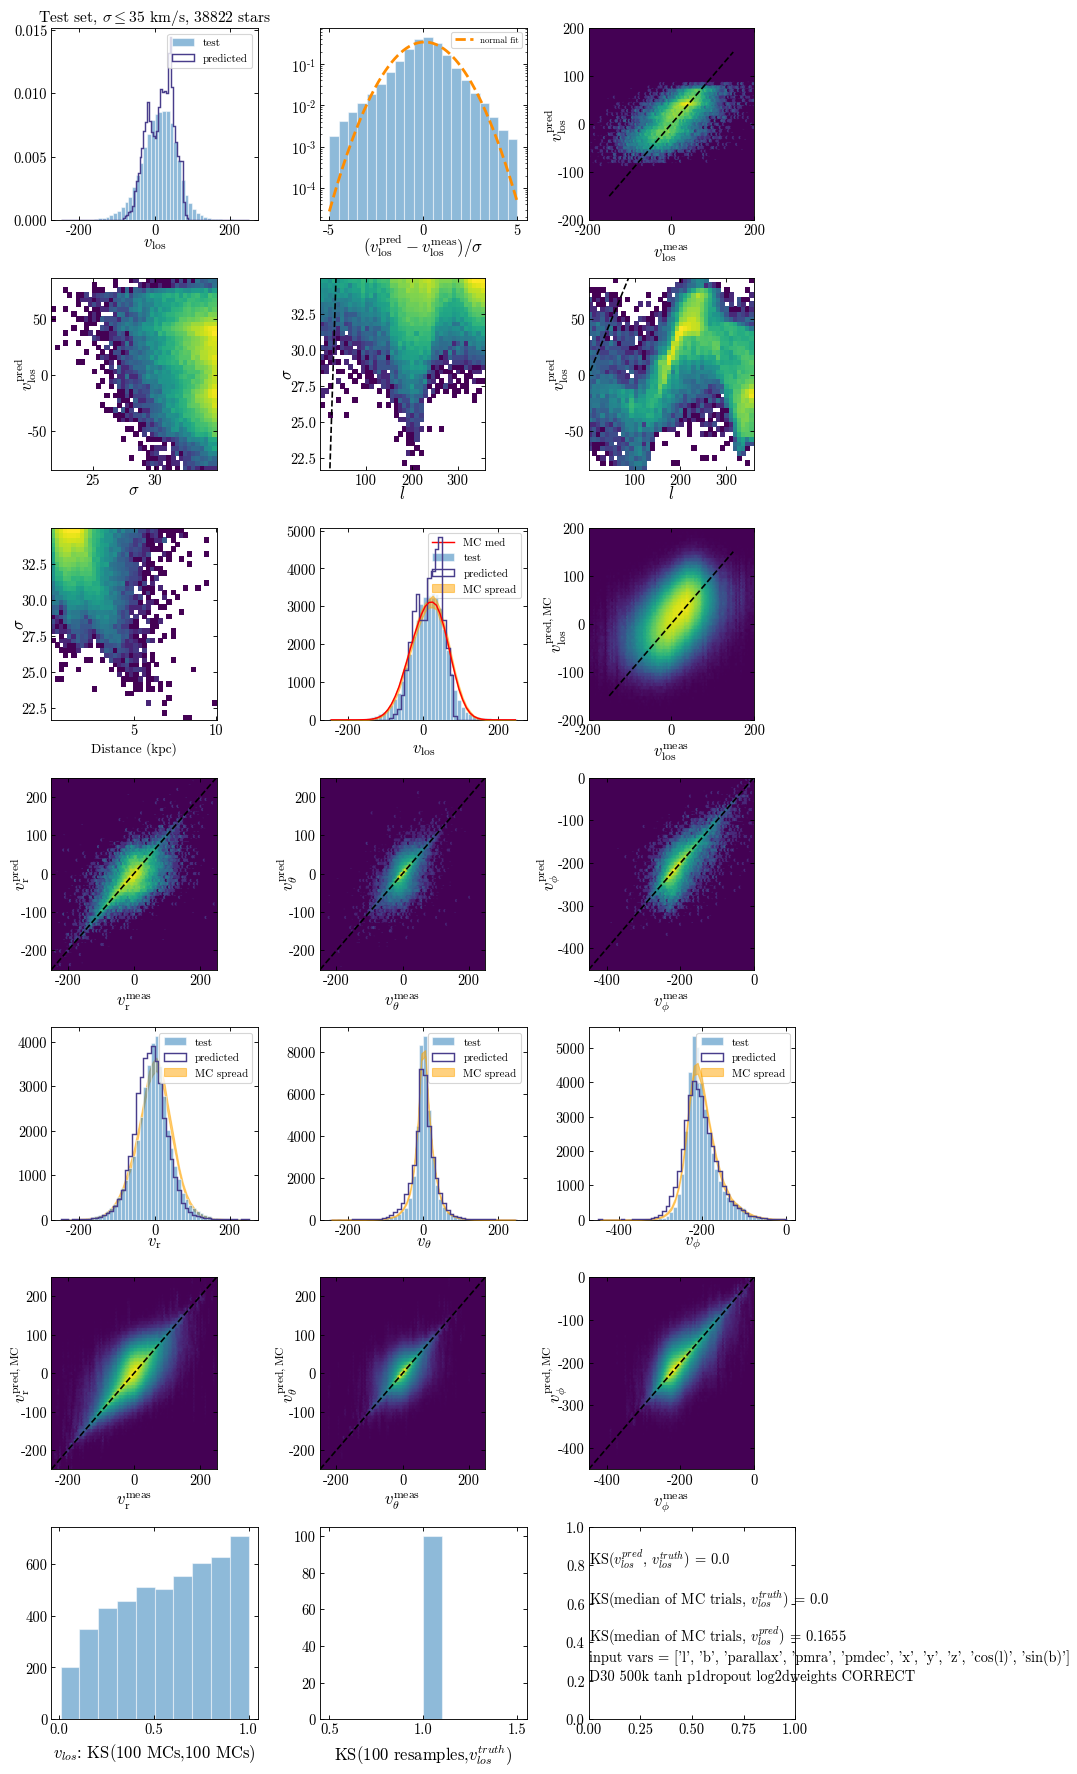

In [59]:
plot_test(35)

In [ ]:
plot_test(27)

##### Going to try to find original indices of points with low error in train, validation, and test & retrain without those

In [ ]:
CombinedModel.load_weights('models/' + 'TrainingBoth_0138.hdf5')
test_preds_train = CombinedModel.predict(X_train)

list_rv_train_err_lt65 = [y_train[i,0] for i in range(len(test_preds_train[:,1])) if test_preds_train[i,1] < 90]
for i in range(len(list_rv_train_err_lt65)):
    indices.append(data[data['radial_velocity']==(list_rv_train_err_lt65[i])].index[0])

In [ ]:
test_preds_val = CombinedModel.predict(X_val)

list_rv_val_err_lt65 = [y_val[i,0] for i in range(len(test_preds_val[:,1])) if test_preds_val[i,1] < 90]
for i in range(len(list_rv_val_err_lt65)):
    indices.append(data[data['radial_velocity']==(list_rv_val_err_lt65[i])].index[0])